# Imports

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms, utils
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import (
    exponential_moving_standardize, preprocess, Preprocessor)
from braindecode.preprocessing import \
    create_windows_from_events, create_fixed_length_windows
import pandas as pd
import numpy as np


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-11 12:58:56.639601: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-11 12:58:56.639630: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-11 12:58:56.639656: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-11 12:58:56.646152: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized 

Tensorflow not install, you could not use those pipelines


# Creating function to get EEG Data

## Preprocess Function

In [2]:
def preprocessor(
    dataset,
    low_cut_hz = 4.,   # low cut frequency for filtering
    high_cut_hz = 38., # high cut frequency for filtering
    newfreq = 100, # Paramater for resampling
    factor = 1e6, # Parameter for scaling
    ):

    preprocessors = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
        Preprocessor(lambda data: np.multiply(data, factor)),  # Convert from V to uV
        Preprocessor("resample", sfreq=newfreq), # Resampling
        Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
        Preprocessor("set_eeg_reference", ref_channels="average", ch_type="eeg") # Common Average Reference
    ]
    
    # Transform the data
    # return preprocess(dataset, preprocessors, n_jobs = -1)
    return preprocess(dataset, preprocessors)


## Get Windows from Dataset function

In [3]:
def get_windows(
        dataset, 
        trial_start_offset_samples=0,
        trial_stop_offset_samples=100,
        window_size_samples=400,
        window_stride_samples=100,
        preload=True,
        # mapping = {'left_hand': 0, 'right_hand': 1},
        picks = ['C3', 'Cz', 'C4']
        ):
    
    windows_dataset = create_windows_from_events(
        dataset,
        trial_start_offset_samples = trial_start_offset_samples,
        trial_stop_offset_samples  = trial_stop_offset_samples,
        window_size_samples        = window_size_samples,
        window_stride_samples      = window_stride_samples,
        preload                    = True,
        # mapping = {'left_hand': 0, 'right_hand': 1},
        picks                      = picks
        )
    
    return windows_dataset


def get_tensors_from_windows(windows_dataset):
    windows_list = []
    labels_list = []
    n_runs = len(windows_dataset.datasets)
    for i in range(n_runs):
        windows_list.append(windows_dataset.datasets[i].windows.get_data())
        labels_list.append(windows_dataset.datasets[i].y)
        
    stacked_tensor = np.concatenate(windows_list, axis=0)
    stacked_labels = np.concatenate(labels_list, axis=0)
    
    del windows_list,labels_list
    
    return stacked_tensor, stacked_labels

# Creating EEG Dataset Class

In [4]:
class EEG(Dataset):

    def __init__(self, subject_id = 3, dataset_name="BNCI2014_001", transform = None):
        
        self.raw_dataset     = MOABBDataset(dataset_name = dataset_name, subject_ids=[subject_id])
        self.prepro_dataset  = preprocessor(self.raw_dataset)
        self.windows_dataset = get_windows(self.prepro_dataset)
        self.data            = get_tensors_from_windows(self.windows_dataset)
        self.transform       = transform
        self.classes         = self.windows_dataset.datasets[0].windows.event_id
        
    def __len__(self):
        return self.data[0].shape[0]

        
    def __getitem__(self,idx):
        
        # sample = {'signal': torch.from_numpy(self.data[0])[idx], 'label': torch.from_numpy(self.data[1])[idx]}
        
        sample = (torch.from_numpy(np.expand_dims(self.data[0], axis = 1))[idx], torch.from_numpy(self.data[1])[idx])
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [5]:
my_eeg_data = EEG()

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/usr/local/lib/python3.11/dist-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB sto

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB sto

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB sto

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB sto

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand',

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [6]:
my_eeg_data[0][0].shape

torch.Size([1, 3, 400])

# Creating CGAN

## Generator

In [7]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels of the output eeg, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=68, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4,      kernel_size = (1,60), stride = (1,1)),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size = (1,60), stride = (1,1)),
            self.make_gen_block(hidden_dim * 2, hidden_dim,     kernel_size = (1,60), stride = (1,1)),
            self.make_gen_block(hidden_dim, im_chan,            kernel_size = (3,50), stride = (1,2), padding = (0,2), final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size, stride, padding = 0, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

## Discriminator

In [8]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels of the output eeg, a scalar
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=5, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim,        kernel_size = (1,50), stride = (2,4)),
            self.make_disc_block(hidden_dim, hidden_dim * 2, kernel_size = (1,50), stride = (2,4)),
            self.make_disc_block(hidden_dim * 2, 1,          kernel_size = (1,10), stride = (2,1), final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size, stride, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Class Input

In [9]:
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels,n_classes)

def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    combined = torch.cat((x.float(),y.float()), 1)
    return combined

## Trainning

In [10]:
# eeg_shape = (1, 3, 400)
eeg_shape = my_eeg_data[0][0].shape
n_classes = 4

In [11]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 100
lr = 0.0002
device = 'cuda'


In [12]:
# dataloader
dataloader = DataLoader(my_eeg_data, batch_size=batch_size,
                        shuffle=True)

for i_batch, (signal,label) in enumerate(dataloader):
    print(i_batch, signal.size(),
      label.size())
    break

0 torch.Size([100, 1, 3, 400]) torch.Size([100])


In [13]:
def get_input_dimensions(z_dim, eeg_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        eeg_shape: the shape of each EEG data as (C, W, H), which is (1, 3, 400), that is, we choose 3 channels (3 electrodes)
        n_classes: the total number of classes in the dataset, an integer scalar
                (4 for EEG, that is 4 movements - tongue, left hand, right hand and feet)
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 3 x 400 for EEG)
    '''
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = eeg_shape[0] + n_classes
    return generator_input_dim, discriminator_im_chan

In [14]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, eeg_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

 17%|█▋        | 2/12 [00:00<00:03,  3.31it/s]

Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!


 67%|██████▋   | 8/12 [00:01<00:00,  5.77it/s]

Step 500: Generator loss: 0.9066839933991432, discriminator loss: 0.5861655489802361


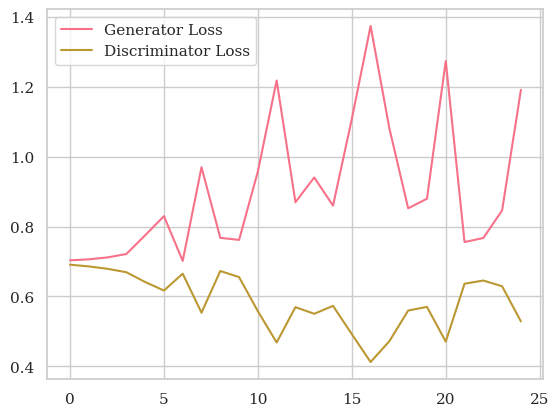

 75%|███████▌  | 9/12 [00:01<00:00,  5.25it/s]


KeyboardInterrupt: 

In [15]:
cur_step = 0
generator_losses = []
discriminator_losses = []

for epoch in range(n_epochs):
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)
    
        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        eeg_one_hot_labels = one_hot_labels[:, :, None, None]
        eeg_one_hot_labels = eeg_one_hot_labels.repeat(1, 1, eeg_shape[1], eeg_shape[2])
    
        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
    
        # Now we can get the eeg data from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake eeg
        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)
    
        # Now we can get the predictions from the discriminator
        # Steps: 1) Create the input for the discriminator
        #           a) Combine the fake images with image_one_hot_labels, 
        #              remember to detach the generator (.detach()) so you do not backpropagate through it
        #           b) Combine the real images with image_one_hot_labels
        #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
        #        3) Get the discriminator's prediction on the reals as disc_real_pred
        
        fake_image_and_labels = combine_vectors(fake, eeg_one_hot_labels)
        real_image_and_labels = combine_vectors(real, eeg_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels.detach())
        disc_real_pred = disc(real_image_and_labels)
    
    
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 
    
        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]
    
        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()
    
        fake_image_and_labels = combine_vectors(fake, eeg_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()
    
        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]
    
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()

        elif cur_step == 0:
            print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
        cur_step += 1

# Exploration

In [ ]:
# Function to generate samples

def generate_samples(label, n_samples, generator):
    '''
    Function for generating samples, once the generator has been trained
        label: label of the movement to be sampled. See dictionary below
        {'feet': 0, 'left_hand': 1, 'right_hand': 2, 'tongue': 3}
        n_samples: number of samples to be generated
        generator: the trained generator
    '''

    noise_4_gen = get_noise(n_samples, z_dim, device=device)
    label = get_one_hot_labels(torch.Tensor([label]).long(), n_classes).repeat(n_samples,1)
    
    noise_and_labels = combine_vectors(noise_4_gen, label.to(device))
    fake = gen(noise_and_labels)
    return fake


In [ ]:
# Before you explore, you should put the generator
# in eval mode, both in general and so that batch norm
# doesn't cause you issues and is using its eval statistics
gen = gen.eval()

In [ ]:
# Remembering labels
print(my_eeg_data.windows_dataset.datasets[0].windows.event_id)

# Computing Dimensions for GAN

In [ ]:
from math import floor

def compute_dim_TransConv2D(Hin, 
                        kernel_size=1, 
                        stride=1,
                        padding = 0,
                        dilation = 1,
                        output_padding = 0
        
        ):
    return ((Hin - 1)*stride) - (2*padding)+ (dilation*(kernel_size - 1)) + output_padding + 1

def compute_dim_Conv2D(Hin, 
                kernel_size=50, 
                stride=4,
                padding = 0,
                dilation = 1
                ):
    return floor( (Hin + (2*padding) - (dilation*(kernel_size-1)) -1)/(stride) + 1 ) 

## For EEG CG


In [ ]:
compute_dim_Conv2D(compute_dim_Conv2D(compute_dim_Conv2D(400)), kernel_size = 10, stride = 1 )

In [ ]:
compute_dim_TransConv2D(compute_dim_TransConv2D(compute_dim_TransConv2D(1)))